In [2]:
import pandas as pd
print(pd.read_csv('/home/guilherme/Documentos/archive/symbols_valid_meta.csv').head())


  Nasdaq Traded Symbol                                      Security Name  \
0             Y      A            Agilent Technologies, Inc. Common Stock   
1             Y     AA                    Alcoa Corporation Common Stock    
2             Y   AAAU                       Perth Mint Physical Gold ETF   
3             Y   AACG  ATA Creativity Global - American Depositary Sh...   
4             Y   AADR                AdvisorShares Dorsey Wright ADR ETF   

  Listing Exchange Market Category ETF  Round Lot Size Test Issue  \
0                N                   N           100.0          N   
1                N                   N           100.0          N   
2                P                   Y           100.0          N   
3                Q               G   N           100.0          N   
4                P                   Y           100.0          N   

  Financial Status CQS Symbol NASDAQ Symbol NextShares  
0              NaN          A             A          N  
1       

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Carregar os tickers da coluna 'symbol'
tickers = pd.read_csv('/home/guilherme/Documentos/archive/symbols_valid_meta.csv')['Symbol'].unique()

# Criar DataFrame para dividendos e lista de erros
dividend_data = pd.DataFrame()
errors = []

# Buscar dados de dividendos
for ticker in tickers:
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        
        # Verificar se temos as informações necessárias
        if 'dividendYield' in info and info['dividendYield'] is not None:
            data = {
                'Ticker': ticker,
                'Dividend_Yield': info['dividendYield'],
                'Annual_Dividend_Rate': info.get('trailingAnnualDividendRate', 0),
                'Market_Price': info.get('regularMarketPrice', 0)
            }
            dividend_data = pd.concat([dividend_data, pd.DataFrame([data])], ignore_index=True)
        else:
            errors.append(f"{ticker}: sem dados de dividend yield")
            
    except Exception as e:
        errors.append(f"Erro em {ticker}: {str(e)}")

# Verificar quantidade de ações processadas e erros
print(f"Total de ações processadas: {len(dividend_data)}")
print(f"Total de erros: {len(errors)}")


404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/AAU?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=AAU&crumb=E1gsA6.0OEu
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ABC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ABC&crumb=E1gsA6.0OEu
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ABMD?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ABMD&crumb=E1gsA6.0OEu
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ACRX?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.co

Total de ações processadas: 2188
Total de erros: 5861


/tmp/ipykernel_223470/3505844884.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dividend_data_clean['target'] = np.where(dividend_data_clean['Dividend_Yield'] > 0.05, 1, 0)


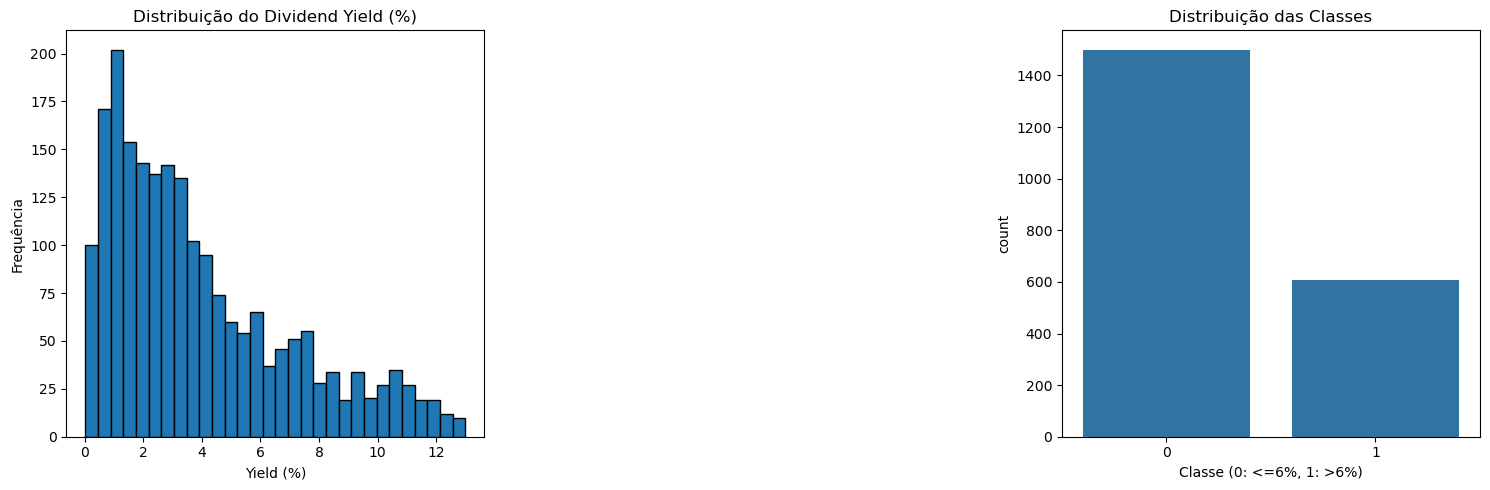


Estatísticas dos Dividend Yields:
count    2107.000000
mean        3.944756
std         3.100014
min         0.020000
25%         1.470000
50%         3.060000
75%         5.705000
max        13.000000
Name: Dividend_Yield_Pct, dtype: float64

Distribuição das classes:
target
0    0.711913
1    0.288087
Name: proportion, dtype: float64


/tmp/ipykernel_223470/3505844884.py:44: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  print(pd.value_counts(dividend_data_clean['target'], normalize=True))


In [4]:
# Converter yield para percentual
dividend_data['Dividend_Yield_Pct'] = dividend_data['Dividend_Yield'] * 100

# Remover outliers usando IQR
Q1 = dividend_data['Dividend_Yield'].quantile(0.25)
Q3 = dividend_data['Dividend_Yield'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

#Filtragem dos Outliers:
dividend_data_clean = dividend_data[
    (dividend_data['Dividend_Yield'] >= lower_bound) & 
    (dividend_data['Dividend_Yield'] <= upper_bound)
]

# Criar target (0 para yield <= 6%, 1 para yield > 6%)
dividend_data_clean['target'] = np.where(dividend_data_clean['Dividend_Yield'] > 0.05, 1, 0)

# Visualização
plt.figure(figsize=(15, 5))

# Histograma de yields
plt.subplot(131)
plt.hist(dividend_data_clean['Dividend_Yield_Pct'], bins=30, edgecolor='black')
plt.title('Distribuição do Dividend Yield (%)')
plt.xlabel('Yield (%)')
plt.ylabel('Frequência')


# Distribuição das classes
plt.subplot(133)
sns.countplot(x='target', data=dividend_data_clean)
plt.title('Distribuição das Classes')
plt.xlabel('Classe (0: <=6%, 1: >6%)')

plt.tight_layout()
plt.show()

# Estatísticas
print("\nEstatísticas dos Dividend Yields:")
print(dividend_data_clean['Dividend_Yield_Pct'].describe())
print(f"\nDistribuição das classes:")
print(pd.value_counts(dividend_data_clean['target'], normalize=True))


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Preparar features
features = ['Dividend_Yield', 'Annual_Dividend_Rate', 'Market_Price']
X = dividend_data_clean[features].values
y = dividend_data_clean['target'].values

# Split dados
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Normalizar
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Verificar formas dos dados
print("\nForma dos dados:")
print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"X_test: {X_test.shape}")



Forma dos dados:
X_train: (1474, 3)
X_val: (316, 3)
X_test: (317, 3)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_84 (Dense)                │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_53          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_54          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_55          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,057 (183.82 KB)

 Trainable params: 46,065 (179.94 KB)

 Non-trainable params: 992 (3.88 KB)

Epoch 1/60
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5390 - auc: 0.4960 - loss: 0.7635 - val_accuracy: 0.9620 - val_auc: 0.9979 - val_loss: 0.5489
Epoch 2/60
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9277 - auc: 0.9690 - loss: 0.3223 - val_accuracy: 0.9114 - val_auc: 0.9989 - val_loss: 0.4414
Epoch 3/60
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9619 - auc: 0.9871 - loss: 0.2245 - val_accuracy: 0.9430 - val_auc: 1.0000 - val_loss: 0.2769
Epoch 4/60
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9670 - auc: 0.9896 - loss: 0.1774 - val_accuracy: 0.9810 - val_auc: 1.0000 - val_loss: 0.1703
Epoch 5/60
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9738 - auc: 0.9928 - loss: 0.1385 - val_accuracy: 0.9778 - val_auc: 1.0000 - val_loss: 0.1134
Epoch 6/60
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9788 - auc: 0.9945 - loss: 0.1176 - val_accuracy: 0.9810 - val_auc: 1.0000 - val_loss: 0.0876
Epoch 7/60
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - 

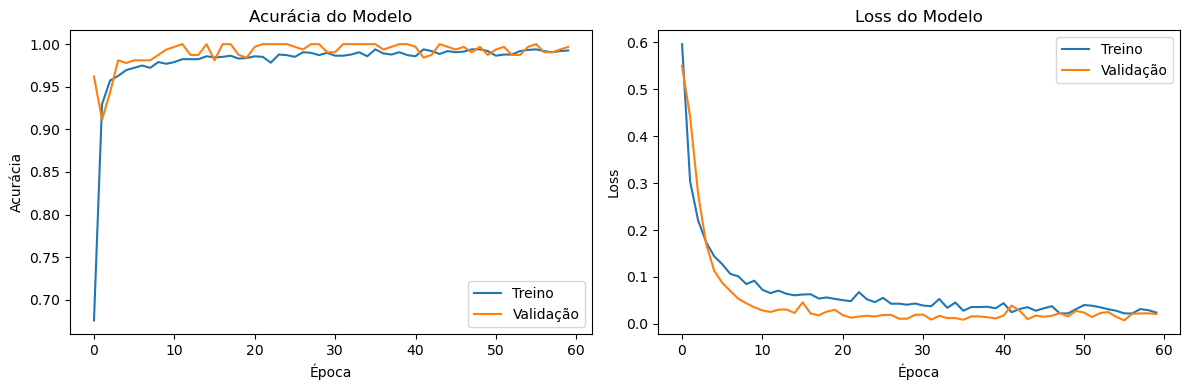


Métricas no conjunto de teste:
Acurácia: 0.9968
AUC: 0.9997
Recall: 0.9670
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


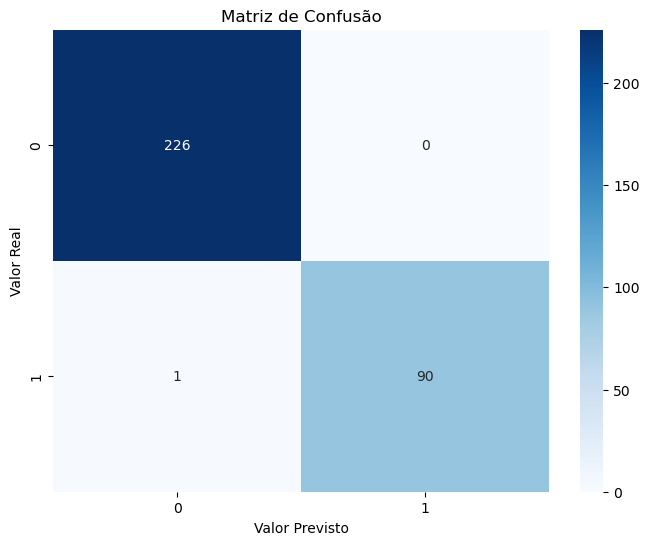


Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       226
           1       1.00      0.99      0.99        91

    accuracy                           1.00       317
   macro avg       1.00      0.99      1.00       317
weighted avg       1.00      1.00      1.00       317



In [19]:
# Célula 1: Importações
import tensorflow as tf

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC, Recall

# Célula 2: Criar um modelo mais complexo
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    
    # Primeira camada densa
    Dense(256, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.1),

    # Segunda camada densa
    Dense(128, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.1),

    # Terceira camada densa
    Dense(64, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.1),
    Dense(32, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(16, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.2),
    
    # Camada densa adicional para aumentar a complexidade
    Dense(16, activation='relu', kernel_initializer='he_normal'),
    
    # Camada de saída com ativação sigmoide para classificação binária
    Dense(1, activation='sigmoid')
])

# Compilar o modelo
optimizer = Adam(learning_rate=0.0005)  
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(name='auc')]
)

# Mostrar a estrutura do modelo
model.summary()

# Célula 3: Definir callbacks com monitoramento de recall
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

# Célula 4: Treinar o modelo
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=60,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)
# Célula 5: Plotar histórico de treinamento
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia do Modelo')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Loss do Modelo')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Célula 6: Avaliar no conjunto de teste
# Avaliar modelo
results = model.evaluate(X_test, y_test, verbose=0)
test_loss, test_accuracy, test_auc = results
print(f"\nMétricas no conjunto de teste:")
print(f"Acurácia: {test_accuracy:.4f}")
print(f"AUC: {test_auc:.4f}")
print(f"Recall: {test_recall:.4f}")

# Fazer previsões
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Célula 7: Plotar matriz de confusão
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.ylabel('Valor Real')
plt.xlabel('Valor Previsto')
plt.show()

# Imprimir relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))
